# Analysis of Elevation Profiles of Hiking Trails

## Introduction 
This project focuses on the analysis of elevation profiles of hiking trails. The data sources used are hiking trails from [OpenStreetMap (OSM)](https://www.openstreetmap.org) and elevation data from the [DMR 5G](https://ags.cuzk.cz/arcgis/rest/services/3D/dmr5g/ImageServer) obtained from the [Czech Office for Surveying, Mapping and Cadastre (ČÚZK)](https://cuzk.cz). The project primarily focuses on hiking trails marked by the [Czech Tourist Club (KČT)](https://www.kct.cz).


## Import of libraries

#### Import standard libraries
[os](https://docs.python.org/3/library/os.html)  
[warnings](https://docs.python.org/3/library/warnings.html)  
[numpy](https://numpy.org/doc/stable/)  

#### Import libraries for data and geospatial data processing
[requests](https://docs.python-requests.org/en/latest/)  
[geopandas](https://geopandas.org/)  
[rasterio](https://rasterio.readthedocs.io/en/latest/)  
[shapely](https://shapely.readthedocs.io/en/stable/)  

#### Import libraries for visualization
[matplotlib](https://matplotlib.org/)  
[folium](https://python-visualization.github.io/folium/)  

#### Import libraries for working with OSM data
[osmapi](https://osmapi.tilmannr.de/)

newer library to work with OSM

[osmnx](https://osmnx.readthedocs.io/en/stable/)  


In [1]:
# Import standard libraries
import os
import warnings
import numpy as np

# Import libraries for data and geospatial data processing
import requests
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString, Polygon
import folium

# Import libraries for visualization
import matplotlib.pyplot as plt

# Import libraries for working with OSM data
import osmapi
import osmnx as ox

The hiking trail relation is downloaded using [OsmApi](https://osmapi.tilmannr.de/). A complete overview of hiking trail numbers in the Czech Republic is available [here](https://osm.paws.cz/hiking.php).

In [2]:
# Function to download a relation by its ID
def download_relation(relation_id):
    try:
        with osmapi.OsmApi() as api:
            return api.RelationGet(relation_id)
    except osmapi.errors.ElementDeletedApiError:
        print(f"Relation with ID {relation_id} not found.")
        return None

Example Usage

In [3]:
# Example ID
relation_id = 334313
relation = download_relation(relation_id)
print(relation)

{'id': 334313, 'visible': True, 'version': 48, 'changeset': 159671790, 'timestamp': datetime.datetime(2024, 11, 27, 18, 14, 37), 'user': 'sannorra', 'uid': 1424365, 'tag': {'complete': 'yes', 'educational': 'yes', 'kct_yellow': 'major', 'name': 'Sigmondova okružní naučná stezka', 'network': 'lwn', 'note': 'Značena žlutým pásovým značením', 'official_name': 'Sigmondova okružní NS', 'operator': 'cz:KČT', 'osmc:symbol': 'yellow:white:yellow_bar', 'ref': '6711', 'route': 'hiking', 'type': 'route'}, 'member': [{'type': 'node', 'ref': 364493953, 'role': 'guidepost'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 676475796, 'role': 'guidepost'}, {'type': 'node', 'ref': 655359905, 'role': 'guidepost'}, {'type': 'node', 'ref': 806808290, 'role': 'guidepost'}, {'type': 'node', 'ref': 2205940692, 'role': 'board'}, {'type': 'node', 'ref': 2205940676, 'role': 'board'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 7099707271, 'ro

In [4]:
# Function to extract descriptive route information from a relation
def extract_route_info(relation):
    tags = relation.get('tag', {})
    route_info = {
        'id': relation['id'],
        'name': tags.get('name', 'Name not provided'),
        'official_name': tags.get('official_name', 'Official name not provided'),
        'route_type': tags.get('route', 'Unknown route type'),
        'operator': tags.get('operator', 'Operator not provided'),
        'symbol': tags.get('osmc:symbol', 'Symbol not provided'),
        'ref': tags.get('ref', 'Reference not provided'),
        'complete': tags.get('complete', 'Not specified'),
        'educational': tags.get('educational', 'Not specified'),
        'network': tags.get('network', 'Unknown network'),
        'kct_yellow': tags.get('kct_yellow', 'Not specified'),
        'note': tags.get('note', 'No note provided'),
    }
    return route_info

In [5]:
# Extract descriptive path information
route_info = extract_route_info(relation)

# Print descriptive path information
print("Descriptive information about the path:")
for key, value in route_info.items():
    print(f"{key}: {value}")

Descriptive information about the path:
id: 334313
name: Sigmondova okružní naučná stezka
official_name: Sigmondova okružní NS
route_type: hiking
operator: cz:KČT
symbol: yellow:white:yellow_bar
ref: 6711
complete: yes
educational: yes
network: lwn
kct_yellow: major
note: Značena žlutým pásovým značením


Function to save relation to geodataframe

In [6]:
def relation_to_geodataframe(relation):
    
    members = relation.get('member', [])
    data = []
    
    for member in members:
        member_type = member.get('type')
        ref = member.get('ref')
        role = member.get('role', '')
        
        if member_type == 'way':
            # Fetch geometry for "way" using the API
            with osmapi.OsmApi() as api:
                way = api.WayGet(ref)
                nodes = way['nd']
                coords = [(api.NodeGet(node_id)['lon'], api.NodeGet(node_id)['lat']) for node_id in nodes]
                geometry = LineString(coords)
                data.append({
                    'type': member_type,
                    'ref': ref,
                    'role': role,
                    'geometry': geometry
                })

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry='geometry')
    return gdf


Example of usage

In [7]:
# Example usage
gdf = relation_to_geodataframe(relation)
display(gdf.head())

,type,ref,role,geometry
0,way,841270075,,"LINESTRING (13.38333 49.78979, 13.38328 49.789..."
1,way,1111089511,,"LINESTRING (13.38315 49.78947, 13.38278 49.789..."
2,way,32399132,,"LINESTRING (13.38224 49.78926, 13.38162 49.789..."
3,way,1111089513,,"LINESTRING (13.38120 49.78914, 13.38107 49.78914)"
4,way,1111089512,,"LINESTRING (13.38107 49.78914, 13.38048 49.78912)"


In [8]:
# Function to determine the trail color from the "osmc:symbol" tag
def get_trail_color(symbol):
    # Examples of mapping the symbol to a color (you can add more symbols as needed)
    if 'yellow' in symbol:
        return 'yellow'
    elif 'red' in symbol:
        return 'red'
    elif 'green' in symbol:
        return 'green'
    elif 'blue' in symbol:
        return 'blue'
    else:
        return 'gray'  # Default color if no match


In [9]:
trail_symbol = route_info.get('symbol')

trail_color = get_trail_color(trail_symbol)

route_name = route_info.get('name', 'No name provided')

In [10]:
# Getting the bounds of the GeoDataFrame (bounding box)
bbox = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Calculate width and height from the bounding box
minx, miny, maxx, maxy = bbox

center = [(miny + maxy) / 2, (minx + maxx) / 2]

m = folium.Map(location=center, zoom_start=14)

gdf.explore(m=m, tiles="carto positron", color=trail_color)

display(m)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


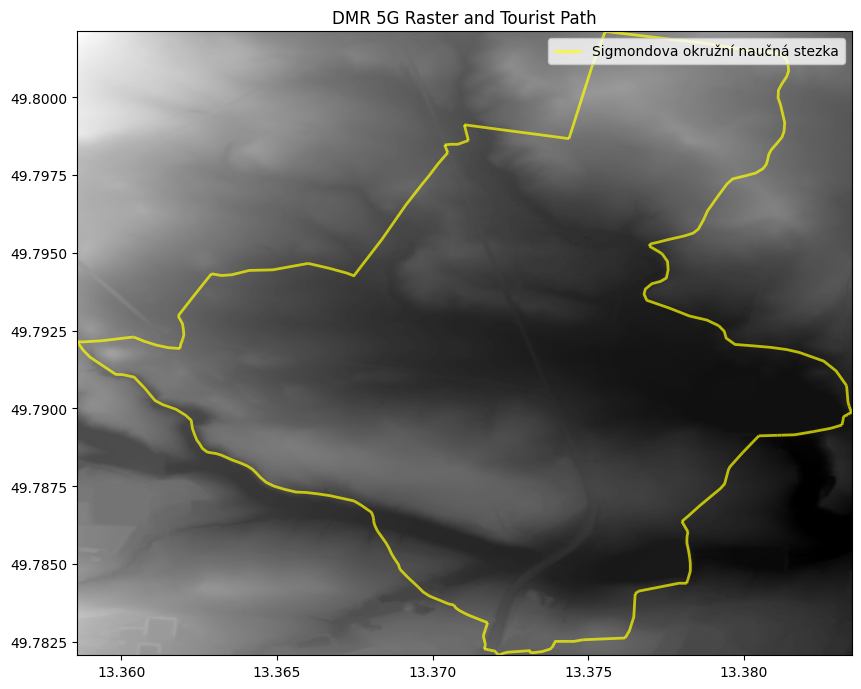

In [11]:
width = maxx - minx
height = maxy - miny

max_size = 1200  # Maximum dimension size (for either width or height)

aspect_ratio = width / height

if width > height:
    image_width = max_size
    image_height = int(image_width / aspect_ratio)
else:
    image_height = max_size
    image_width = int(image_height * aspect_ratio)

url = "https://ags.cuzk.cz/arcgis2/rest/services/dmr5g/ImageServer/exportImage"

params = {
    "bbox": f"{minx},{miny},{maxx},{maxy}",  # Bounding box coordinates (minx, miny, maxx, maxy)
    "bboxSR": 4326,  # Spatial reference for the bounding box (WGS 84)
    "imageSR": 4326,  # Spatial reference for the image (WGS 84)
    "size": f"{image_width},{image_height}",  # Dynamically set image size (in pixels)
    "format": "tiff",  # Output format (TIFF)
    "f": "image"  # Requesting the image (raster data)
}

response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the response content (TIFF file) to a local file
    with open("dmr5g_bounding_box.tif", "wb") as f:
        f.write(response.content)

    #Open the saved TIFF file using rasterio
    with rasterio.open("dmr5g_bounding_box.tif") as src:

        fig, ax = plt.subplots(figsize=(10, 10))
        
        show(src, ax=ax, cmap='gray')
        
        gdf.plot(ax=ax, color=trail_color, alpha=0.7, edgecolor='black', linewidth=2, label=route_name)
        
        # Add a title
        plt.title("DMR 5G Raster and Tourist Path")
        
        # Display the plot
        plt.legend()
        plt.show()

else:
    print(f"Failed to download raster data. Status code: {response.status_code}")

In [12]:
print(gdf.crs)

gdf_length = gdf.set_crs(epsg=4326, allow_override=True)

gdf_length = gdf_length.to_crs(epsg=3395)

gdf_length['length'] = gdf_length.length

gdf_length = gdf_length.set_crs(epsg=4326, allow_override=True)

print(gdf_length.head())

None
  type         ref role                                           geometry  \
0  way   841270075       LINESTRING (1489825.83694 6377301.02636, 14898...   
1  way  1111089511       LINESTRING (1489805.16491 6377244.74842, 14897...   
2  way    32399132       LINESTRING (1489704.50983 6377208.82908, 14896...   
3  way  1111089513       LINESTRING (1489588.91567 6377188.62560, 14895...   
4  way  1111089512       LINESTRING (1489574.29942 6377187.95502, 14895...   

       length  
0   64.134991  
1  107.125845  
2  117.978096  
3   14.631624  
4   66.258150  


In [13]:
with rasterio.open("dmr5g_bounding_box.tif") as src:
    elevation_data = []

    for line in gdf.geometry:
        for coord in line.coords:
            lon, lat = coord

            row, col = src.index(lon, lat)

            if 0 <= row < src.height and 0 <= col < src.width:
                elevation = src.read(1)[row, col]
            else:
                elevation = None
            elevation_data.append({'lon': lon, 'lat': lat, 'elevation': elevation})

elevation_gdf = gpd.GeoDataFrame(
    elevation_data, 
    geometry=gpd.points_from_xy([d['lon'] for d in elevation_data], [d['lat'] for d in elevation_data]),
    crs="EPSG:4326"
)

gdf_length = gdf.set_crs(epsg=4326, allow_override=True)
gdf_length = gdf_length.to_crs(epsg=3395)
gdf_length['length'] = gdf_length.length

gdf['elevation'] = None

for idx, line in gdf.iterrows():
    for coord in line['geometry'].coords:
        lon, lat = coord
        elevation = elevation_gdf[(elevation_gdf['lon'] == lon) & (elevation_gdf['lat'] == lat)]['elevation'].values
        if elevation.size > 0:
            gdf.at[idx, 'elevation'] = elevation[0]
gdf['length'] = gdf_length['length']

print(gdf[['geometry', 'elevation', 'length']])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 107: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "C:\Users\kovar\AppData\Roaming\Python\Python39\site-packages\rasterio\env.py", line 338, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 99: invalid continuation byte


                                             geometry   elevation       length
0   LINESTRING (13.38333 49.78979, 13.38328 49.789...  338.308716    64.134991
1   LINESTRING (13.38315 49.78947, 13.38278 49.789...  338.605347   107.125845
2   LINESTRING (13.38224 49.78926, 13.38162 49.789...  338.640015   117.978096
3   LINESTRING (13.38120 49.78914, 13.38107 49.78914)  338.966461    14.631624
4   LINESTRING (13.38107 49.78914, 13.38048 49.78912)  338.412079    66.258150
5   LINESTRING (13.37996 49.78858, 13.38048 49.78912)  338.412079   108.807852
6   LINESTRING (13.37801 49.78637, 13.37821 49.786...  341.787048   445.037461
7   LINESTRING (13.37801 49.78637, 13.37810 49.786...  344.306091    62.684677
8   LINESTRING (13.37820 49.78603, 13.37818 49.785...  342.365662   138.248276
9   LINESTRING (13.37825 49.78523, 13.37826 49.78518)  342.421173     8.897551
10  LINESTRING (13.37826 49.78518, 13.37828 49.785...  342.928314   119.547118
11  LINESTRING (13.37819 49.78449, 13.37816 49.78438

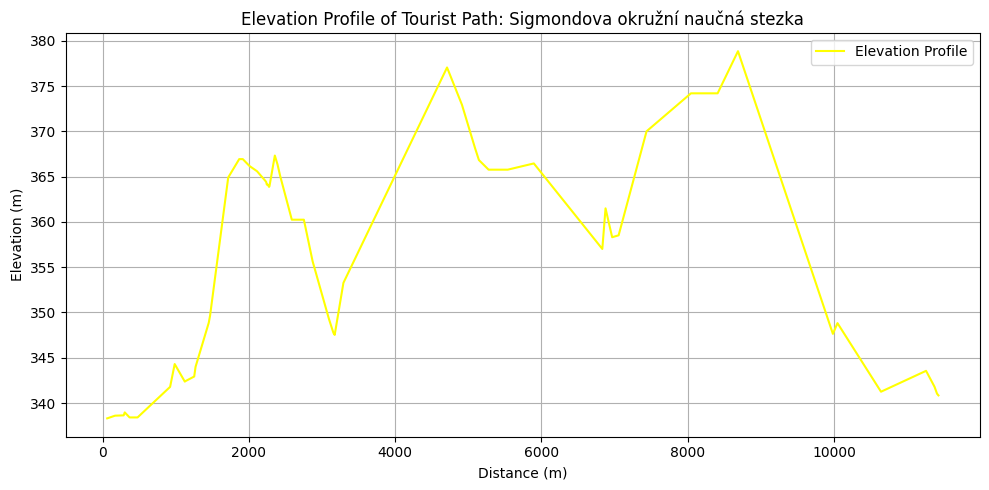

In [14]:
elevations = np.array(gdf['elevation'].dropna())
distances = np.array(gdf['length'].dropna())

cumulative_distances = np.cumsum(distances)


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cumulative_distances, elevations, label='Elevation Profile', color=trail_color)

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title(f'Elevation Profile of Tourist Path: {route_name}')

ax.grid(True)
ax.legend()

plt.tight_layout()

plt.show()


In [15]:
import overpy
import osmapi
from datetime import datetime

# Initialize Overpass API
api = overpy.Overpass()

# Define the area of interest (Kamenec, Czech Republic)
area_name = "Plzeň, Czech Republic"

# Query to get the area ID for Kamenec
area_query = """
[out:json];
area["name"="Plzeň"]["boundary"="administrative"];
out body;
"""

# Get the area ID
area_result = api.query(area_query)
area_id = area_result.areas[0].id

# Query to get the IDs of hiking routes by KČT for the specified area
relation_query = f"""
[out:json];
area({area_id});
relation(area)["route"="hiking"]["operator"="cz:KČT"];
out ids;
"""

# Fetch data from Overpass API
result = api.query(relation_query)

# Function to download a relation by its ID
def download_relation(relation_id):
    try:
        with osmapi.OsmApi() as api:
            return api.RelationGet(relation_id)
    except osmapi.errors.ElementDeletedApiError:
        print(f"Relation with ID {relation_id} not found.")
        return None

# Download all hiking routes by KČT for the specified area
relations = []
for relation in result.relations:
    rel = download_relation(relation.id)
    if rel:
        relations.append(rel)

# Print the relations
for rel in relations:
    print(rel)

{'id': 87590, 'visible': True, 'version': 113, 'changeset': 145588217, 'timestamp': datetime.datetime(2023, 12, 27, 18, 35, 47), 'user': 'Fjana', 'uid': 10630524, 'tag': {'complete': 'yes', 'destinations': 'Plzeň - Doubravka;Malešice', 'kct_yellow': 'major', 'network': 'rwn', 'operator': 'cz:KČT', 'osmc:symbol': 'yellow:white:yellow_bar', 'ref': '6624', 'route': 'hiking', 'source': 'survey', 'source:ref': 'cs.wikipedia.org', 'type': 'route', 'wikidata': 'Q12059946', 'wikipedia': 'cs:Turistická značená trasa 6624'}, 'member': [{'type': 'node', 'ref': 5369697089, 'role': 'guidepost'}, {'type': 'node', 'ref': 5369697091, 'role': 'guidepost'}, {'type': 'node', 'ref': 360280415, 'role': 'guidepost'}, {'type': 'node', 'ref': 360280265, 'role': 'guidepost'}, {'type': 'node', 'ref': 444725116, 'role': 'guidepost'}, {'type': 'node', 'ref': 360808097, 'role': 'guidepost'}, {'type': 'node', 'ref': 360251906, 'role': 'guidepost'}, {'type': 'node', 'ref': 360251902, 'role': 'guidepost'}, {'type': '

In [16]:
for rel in relations:
    route_info = extract_route_info(rel)
    print("Descriptive information about the path:")
    for key, value in route_info.items():
        print(f"{key}: {value}")
    print("\n")

Descriptive information about the path:
id: 87590
name: Name not provided
official_name: Official name not provided
route_type: hiking
operator: cz:KČT
symbol: yellow:white:yellow_bar
ref: 6624
complete: yes
educational: Not specified
network: rwn
kct_yellow: major
note: No note provided


Descriptive information about the path:
id: 132429
name: Name not provided
official_name: Official name not provided
route_type: hiking
operator: cz:KČT
symbol: green:white:green_bar
ref: 3601
complete: yes
educational: Not specified
network: rwn
kct_yellow: Not specified
note: No note provided


Descriptive information about the path:
id: 6268435
name: Name not provided
official_name: Official name not provided
route_type: hiking
operator: cz:KČT
symbol: yellow:white:yellow_bar
ref: 6732
complete: yes
educational: Not specified
network: lwn
kct_yellow: major
note: část bývalé 6624 - začíná ve Valše (oddělení od zbytku zjištěno 2016-05);na sever od Valchy přeznačeno (2018-05)


Descriptive informatio

In [17]:
# Convert relations to GeoDataFrame and display the first rows
for rel in relations:
    gdf = relation_to_geodataframe(rel)
    display(gdf.head())

,type,ref,role,geometry
0,way,376865495,,"LINESTRING (13.42411 49.75902, 13.42410 49.758..."
1,way,32089948,,"LINESTRING (13.42429 49.75923, 13.42430 49.759..."
2,way,32089951,,"LINESTRING (13.42311 49.75909, 13.42340 49.759..."
3,way,28983077,,"LINESTRING (13.42264 49.76033, 13.42286 49.759..."
4,way,28983078,,"LINESTRING (13.42252 49.76046, 13.42264 49.76033)"


,type,ref,role,geometry
0,way,437105531,,"LINESTRING (12.99258 50.05080, 12.99255 50.05091)"
1,way,364615133,,"LINESTRING (12.99654 50.05037, 12.99596 50.050..."
2,way,364615126,,"LINESTRING (13.00940 50.05012, 13.00930 50.050..."
3,way,364615125,,"LINESTRING (13.01505 50.05073, 13.01455 50.050..."
4,way,364615122,,"LINESTRING (13.02277 50.04773, 13.02242 50.048..."


,type,ref,role,geometry
0,way,274678008,,"LINESTRING (13.31432 49.71512, 13.31380 49.714..."
1,way,688417198,,"LINESTRING (13.31432 49.71512, 13.31460 49.715..."
2,way,688417202,,"LINESTRING (13.31599 49.71579, 13.31664 49.716..."
3,way,131567315,,"LINESTRING (13.32117 49.71748, 13.32090 49.717..."
4,way,688417203,,"LINESTRING (13.32143 49.71737, 13.32117 49.71748)"


,type,ref,role,geometry
0,way,80913434,,"LINESTRING (13.34812 49.76938, 13.34773 49.769..."
1,way,556522461,,"LINESTRING (13.34812 49.76938, 13.34809 49.769..."
2,way,196755955,,"LINESTRING (13.34720 49.76865, 13.34714 49.768..."
3,way,837865974,,"LINESTRING (13.34206 49.77011, 13.34213 49.770..."


In [18]:
# Getting the bounds of the GeoDataFrame (bounding box)
bbox = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Calculate width and height from the bounding box
minx, miny, maxx, maxy = bbox

center = [(miny + maxy) / 2, (minx + maxx) / 2]

m = folium.Map(location=center, zoom_start=14)

gdf.explore(m=m, tiles="carto positron", color=trail_color)

display(m)